## Import important libraries

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
import optuna
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

## Dataset information

In [8]:
# train path:
train_path = '../data/train.csv'
# test path:
test_path = '../data/test.csv'
# load train data:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')
print(train.head())
print('Train data contains {} rows and {} features'.format(train.shape[0], train.shape[1]))

print(test.head())
print('Test data contains {} rows and {} features'.format(test.shape[0], test.shape[1]))

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ... 

### Missing values

In [9]:
# Concat test and train data:
all_data = pd.concat([train, test])
all_data.tail(10)

# Vsiualize the percentages of missing values per features:
missing_values = pd.DataFrame({'Percentage' : (all_data.isnull().sum()/len(all_data)) * 100}, 
                              index=all_data.columns)
missing_values = missing_values[missing_values['Percentage']>0].sort_values(
    by='Percentage', 
    ascending=False)
missing_values.drop(index='SalePrice', inplace=True)
missing_values.head(10)

,Percentage
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageYrBlt,5.447071
GarageFinish,5.447071


### Categorical and continuous columns

In [10]:
continuous_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
continuous_features.remove('SalePrice')
print('There are {} continuous features and {} categorical features'.format(len(continuous_features), len(categorical_features)))
print('Continuous features: ', continuous_features)
print('Categorical features: ', categorical_features)   

There are 36 continuous features and 43 categorical features
Continuous features:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Elect

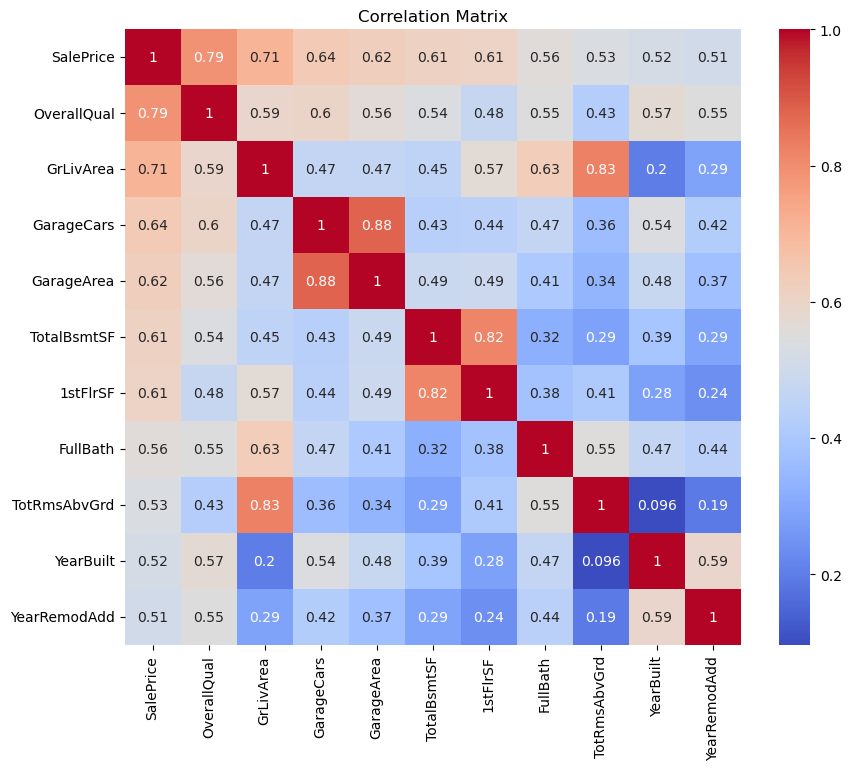

In [11]:
# Calculating correlations :
train_corr = train.select_dtypes(include=[np.number])
# Calculating correlations:
corr = train_corr.corr()
# Sorting correlations with SalePrice:
corr_sorted = corr['SalePrice'].abs().sort_values(ascending=False)
corr_high = corr_sorted[corr_sorted>0.5].index
# Subsetting correlations:
corr = corr.loc[corr_high, corr_high]
# Visualize the heatmap:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## Baseline
* preserve all the features
* fill NA with median value
* single XGBoost model

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

test_id = test['Id']

train.drop(['Id'], axis=1, inplace=True)

continuous_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
discret_columns = train.select_dtypes(include=['object']).columns.tolist()

for col in discret_columns:
    train[col].fillna(-1,inplace=True)
    test[col].fillna(-1,inplace=True)
    res1 = train[col].value_counts().keys()
    res2 = test[col].value_counts().keys()
    res = list(set(res1).union(set(res2)))
    mapping = dict(zip(res, range(len(res))))
    print(f'{col}:{mapping}')
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping)

train.to_csv('../data/train_pro.csv',index=False)
test.to_csv('../data/test_pro.csv',index=False)


MSZoning:{'RM': 0, 'C (all)': 1, 'RH': 2, 'FV': 3, 'RL': 4, -1: 5}
Street:{'Pave': 0, 'Grvl': 1}
Alley:{'Pave': 0, 'Grvl': 1, -1: 2}
LotShape:{'IR2': 0, 'Reg': 1, 'IR1': 2, 'IR3': 3}
LandContour:{'HLS': 0, 'Bnk': 1, 'Lvl': 2, 'Low': 3}
Utilities:{'NoSeWa': 0, 'AllPub': 1, -1: 2}
LotConfig:{'CulDSac': 0, 'Inside': 1, 'Corner': 2, 'FR3': 3, 'FR2': 4}
LandSlope:{'Sev': 0, 'Gtl': 1, 'Mod': 2}
Neighborhood:{'Blueste': 0, 'NridgHt': 1, 'NoRidge': 2, 'Timber': 3, 'BrDale': 4, 'Gilbert': 5, 'Somerst': 6, 'SWISU': 7, 'OldTown': 8, 'Mitchel': 9, 'BrkSide': 10, 'Crawfor': 11, 'MeadowV': 12, 'CollgCr': 13, 'NAmes': 14, 'NWAmes': 15, 'SawyerW': 16, 'Veenker': 17, 'ClearCr': 18, 'Sawyer': 19, 'StoneBr': 20, 'IDOTRR': 21, 'Blmngtn': 22, 'Edwards': 23, 'NPkVill': 24}
Condition1:{'Artery': 0, 'Feedr': 1, 'RRNn': 2, 'PosA': 3, 'RRAn': 4, 'PosN': 5, 'Norm': 6, 'RRAe': 7, 'RRNe': 8}
Condition2:{'Artery': 0, 'Feedr': 1, 'RRNn': 2, 'PosA': 3, 'PosN': 4, 'RRAn': 5, 'Norm': 6, 'RRAe': 7}
BldgType:{'2fmCon': 0

## 划分训练集和验证集

In [13]:
def split_train_val(X, y, ratio=0.8, seed=42):
    """
    划分训练集和验证集
    :param X: 特征
    :param y: 标签
    :param ratio: 训练集比例
    :return: X_train, y_train, X_val, y_val
    """
    np.random.seed(seed)
    n = X.shape[0]
    y = y.astype(int)
    indices = np.arange(n)
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]
    split = int(n * ratio)
    X_train, y_train = X[:split], y[:split]
    X_val, y_val = X[split:], y[split:]
    return X_train, y_train, X_val, y_val


### 训练

In [14]:
config={
    'ratio':0.8,
    'seed':42
}
df = pd.read_csv('../data/train_pro.csv')
data = df.values
n = data.shape[0]
X = data[:,:-1]
y = data[:,-1]

X_train, y_train, X_val, y_val = split_train_val(X, y, config.get('ratio'), seed=config.get('seed'))
#choose the best model
xgb_model = XGBRegressor(learning_rate=0.015,n_estimators=4750,max_depth=3,min_child_weight=0,subsample=0.7,colsample_bytree=0.4064,nthread=-1,scale_pos_weight=2,seed=42)
xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)])


df_test = pd.read_csv('../data/test_pro.csv')
data_test = df_test.values
X_test = data_test[:,1:]
pred = xgb_model.predict(X_test)
pred_train = xgb_model.predict(X_train)
submission = pd.DataFrame({
    'Id': data_test[:,0].astype(int),  # Assuming test set has an 'Id' column
    'SalePrice': pred # Replace 'Target' with the name of your target column
})

# Save the submission file
submission.to_csv('../res/submission.csv', index=False)

[0]	validation_0-rmse:71616.86552
[1]	validation_0-rmse:70881.74868
[2]	validation_0-rmse:70201.21366
[3]	validation_0-rmse:69522.94016
[4]	validation_0-rmse:68788.65389
[5]	validation_0-rmse:68110.11313
[6]	validation_0-rmse:67553.79781
[7]	validation_0-rmse:66913.52841
[8]	validation_0-rmse:66313.62506
[9]	validation_0-rmse:65716.07924
[10]	validation_0-rmse:65219.10047
[11]	validation_0-rmse:64703.66605
[12]	validation_0-rmse:64046.05018
[13]	validation_0-rmse:63374.01257
[14]	validation_0-rmse:62714.99711
[15]	validation_0-rmse:62079.07436
[16]	validation_0-rmse:61508.39729
[17]	validation_0-rmse:60944.25353
[18]	validation_0-rmse:60456.57634
[19]	validation_0-rmse:59937.54429
[20]	validation_0-rmse:59368.23651
[21]	validation_0-rmse:58990.06742
[22]	validation_0-rmse:58462.62785
[23]	validation_0-rmse:57922.88514
[24]	validation_0-rmse:57390.15146
[25]	validation_0-rmse:56834.78704
[26]	validation_0-rmse:56337.77860
[27]	validation_0-rmse:55842.68835
[28]	validation_0-rmse:55391.6

### 测试并提交

In [15]:

data_test = test.values
X_test = data_test[:,1:]
pred = xgb_model.predict(X_test)
pred_train = xgb_model.predict(X_train)
submission = pd.DataFrame({
    'Id': data_test[:,0].astype(int),  # Assuming test set has an 'Id' column
    'SalePrice': pred # Replace 'Target' with the name of your target column
})

# Save the submission file
submission.to_csv('../res/submission_baseline.csv', index=False)